# ADS Take Home Assignment

## Alex Vand - February 2024

### Purpose of Assignment

The goal of this assignment is to QA/QC, analyze, and draw insights from geologic data.

First, import the necessary packages to complete the assignment.

In [137]:
import pandas as pd # package for data analysis
import numpy as np # package used for "replace" -- is this used otherwise?

In [138]:
from matplotlib import pyplot as plt # package used for data visualization -- is this package used/ needed?

Next, read in the raw dataframe.

In [139]:
df = pd.read_csv("kobold_data\ADS_Exercise_data\MN_geochem_ads.csv") # read in the raw dataframe

The following code chunk displays exploratory information about the dataframe.

In [140]:
df.info(memory_usage='deep') # view basic exploratory information about the dataframe including column names and data types
# 'deep' does a real calclulation of the memory usage, instead of estimated

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sample          305 non-null    int64  
 1   medium          305 non-null    object 
 2   easting_wgs84   305 non-null    float64
 3   northing_wgs84  304 non-null    float64
 4   date_assay      305 non-null    object 
 5   company         305 non-null    object 
 6   structure       110 non-null    object 
 7   lithology       289 non-null    object 
 8   Co_ppm          302 non-null    float64
 9   Cu_ppm          242 non-null    float64
 10  Ni_ppm          305 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 127.1 KB


This rawa dataset contains 11 columns (variables of interest) and 305 rows (observations or potential mining locations). Additionally, there are both numerical (float64 and int64) and string (object) data types.

As shown in the output above under "Non-Null Count", several variables contain less than 305 non-null entries. This indicates there are several null, NA, or blank variables that must be accounted for.

The first task of this assignment is to clean the raw dataset so that later we can perform statistical and geospatial analysis.

# Data Cleaning

To clean this dataset: (1) duplicate values must be removed; (2) any incorrect data points must be fixed; and (3) NA values must be addressed. Various programmatical tests, as well as general data exploration, will be incorporated to determine if any data points were inputted in error.

## Duplicates

The "sample" ID column is the unique key to identify each data point. Therefore, we can use this column to search for any duplicate entries in the data set and delete those rows. The code belows displays all the duplicate values.

In [141]:
df[df.duplicated(['sample'], keep = False)] # "keep = false" displays all duplicates instead of ignoring the first or last

,sample,medium,easting_wgs84,northing_wgs84,date_assay,company,structure,lithology,Co_ppm,Cu_ppm,Ni_ppm
223,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basaltt,42.0,100.0,41
233,9497345,rock_outcrop,-90.41667,47.75,4/5/89,united_states_geological_survey,lava flow,basalt.,59.0,83.0,172
300,9497345,rock_outcrop,-90.41667,47.75,4/5/89,united_states_geological_survey,lava flow,basalt,36.0,110.0,41
301,9497345,rock_outcrop,-90.41667,47.75,4/5/89,united_states_geological_survey,lava flow,basalt,52.0,58.0,242
302,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,Basalt,42.0,100.0,41
303,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basalt,42.0,100.0,41
304,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basalt,42.0,100.0,41


Sample 9497291 has all the same values, for all variables, for all 4 duplicate entries [indices 223, 302, 303, 304]. Therefore, we can delete all repeated duplicates and just keep the first entry, as is done in the code chunk below.

In [142]:
# drops duplicate row across all variables and updates dataframe
df.drop_duplicates(subset=['sample','Co_ppm','Cu_ppm','Ni_ppm'], keep='first', inplace=True)
df.shape

(302, 11)

The dataframe now has 302 rows, which means 3 repeated observations for sample 9497291 were deleted, as expected.

Sample 9497345, however, has different values for the metal concentrations for all 3 duplicate entries [indices 233, 300, 301]. This implies we cannot keep any of the 3 data points in our dataframe as we do not know which one is correct. If possible, we could refer to the metadata or ask the field team to answer any potential questions. Given the resources currently availalbe, we could consider taking the average value of the 3 duplicate data entries and including that number in our clean dataset. However the mineral concentration values are very different across these 3 duplicate entries, so for the sake of this exercise, these data points will be considered NA values, and will therefore be omitted. Alternatively, another potential option is to assign a new sample number or identifier to each of the duplicate samples that have different mineral concentration values. For example, indices 300 and 301 could be assigned new sample numbers and those data points could be included in the final clean dataset. Since these 3 data points have the same GPS coordinates, it is not logical to keep all three values for the same location.

In [143]:
# drops duplicate row across all variables and updates dataframe
df.drop_duplicates(subset=['sample'], keep=False, inplace=True)
df.shape

(299, 11)

The dataframe now has 299 rows, which means the 3 observations for sample 9497345 were deleted, as expected.

In the next section, we will visit some data entry errors and rectify the apparent mistakes and typos.

## Latitude and Longitude Errors

There are several data points where the latitude ("northing_wgs84") and longitude ("easting_wgs84") are flipped and/or one of the values has the incorrect positive or negative sign. These data points must be corrected so they can be included in the calculations for spatial analysis. Below we see a map of all of our raw data points.

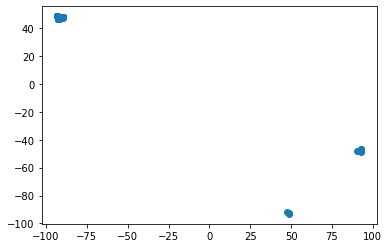

In [144]:
plt.scatter(df['easting_wgs84'], df['northing_wgs84'])

At first glance, it looks like the data cover three distinct geographical regions. However, upon closer examination of the northing and easting data, it becomes apparent that some of these data points might have be inputted in the wrong column.

In [145]:
easting_min = df['easting_wgs84'].min()
easting_max = df['easting_wgs84'].max()

print("The range for 'easting_wgs84' is between", easting_min, "and", easting_max, "degrees.")

The range for 'easting_wgs84' is between -93.35 and 92.93611 degrees.


In [146]:
northing_min = df['northing_wgs84'].min()
northing_max = df['northing_wgs84'].max()

print("The range for 'northing_wgs84' is between", northing_min, "and", northing_max, "degrees.")

The range for 'northing_wgs84' is between -93.2 and 48.66667 degrees.


First we will swap any latitude ("northing_wgs84") and longitude ("easting_wgs84") points that appear to be in the opposite column. The following code chunk displays the data points where this switch must occur.

In [147]:
df.loc[(abs(df['easting_wgs84']) < 50)] # lists the data points where lat & long need to swap

,sample,medium,easting_wgs84,northing_wgs84,date_assay,company,structure,lithology,Co_ppm,Cu_ppm,Ni_ppm
21,9177307,rock_outcrop,48.41581,-92.52700,11/6/01,united_states_geological_survey,pluton; stock,granite,3.0,4.0,<1.5
70,9278672,rock_outcrop,48.63333,-93.20000,11/14/83,united_states_geological_survey,xenolith,diorite,66.0,43.0,640
161,9334348,rock,47.61861,-91.93222,1/2/88,united_states_geological_survey,NaN,gabbro,22.5,75.0,75


Next, we will update the dataset and actually switch the northing and easting values for all three data observations listed above.

In [148]:
df[['easting_wgs84','northing_wgs84']] = df[['northing_wgs84',
                                             'easting_wgs84']].where(abs(df['easting_wgs84']) < 50,
                                                                         df[['easting_wgs84','northing_wgs84']].values)

Here we multiply the absolute value of the easting value by -1 to make sure all the longitude values are negative and reflect the same geographic location in the Western Hemisphere.

In [149]:
df['easting_wgs84'] = df['easting_wgs84'].apply(abs)*(-1) # ensures that all longitude values are negative (degrees west)

Below we find the absolute value of all northing values to make sure all the latitude values are positive and reflect the same geographic location in the Northern Hemisphere.

In [150]:
df['northing_wgs84'] = df['northing_wgs84'].apply(abs) # ensures that all latitude values are positive (degrees north)

In the map below, using the updated dataframe, we see that all data points are relegated to the same geogaphical area in Canada.

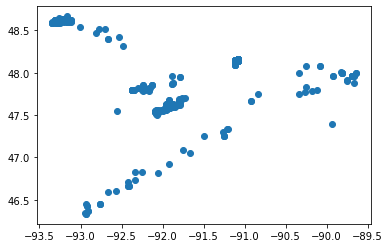

In [151]:
plt.scatter(df['easting_wgs84'], df['northing_wgs84'])

## NA Values

The following code chunk will display the current total number of null (blank) values in the raw dataset.

In [152]:
print(df.isna().sum()) # counts the number of NA (null) values in each column

sample              0
medium              0
easting_wgs84       0
northing_wgs84      1
date_assay          0
company             0
structure         195
lithology          16
Co_ppm              3
Cu_ppm             63
Ni_ppm              0
dtype: int64


Taking a closer look at the mineral concentration values, it becomes apparent that several data points must be fixed, updated, or assigned an NA value.

In [153]:
cobalt_min = df['Co_ppm'].min()
cobalt_max = df['Co_ppm'].max()

print("The range for cobalt is between", cobalt_min, "and", cobalt_max, "ppm.")

The range for cobalt is between -0.1 and 768.0 ppm.


For example, because these ranges of values represent mineral concentrations, negative values are nonsensical. We might make the choice to consider all negative values as NA; however, since the negative values included in this column are within a reasonable range if they were positive, we will convert these values to positive numbers in a later step and keep them for our future analysis.

In [154]:
copper_min = df['Cu_ppm'].min()
copper_max = df['Cu_ppm'].max()

print("The range for copper is between", copper_min, "and", copper_max, "ppm.")

The range for copper is between -99999.0 and 99999.0 ppm.


Furthermore, here we see that the copper values include common NA identifiers such as -99999 and 99999. We must convert these values to NA, as is done in the code chunk below.

In [155]:
df[['Cu_ppm']] = df[['Cu_ppm']].mask(df[['Cu_ppm']] == abs(99999)) # changes 99999 values to NA

In [156]:
nickel_min = df['Ni_ppm'].min()
nickel_max = df['Ni_ppm'].max()

print("The range for nickel is between", nickel_min, "and", nickel_max, "ppm.")

The range for nickel is between -1.25 and <1.5 ppm.


Additionally, the nickel data column has a string (word) value listed for very low concentrations ("<1.5") instead of a number. One option to incorporate these data points with very low nickel concentration is to convert "<1.5" to an arbitrary numerical value by assigning a random low number that is less than 1.5. However, because too many assumptions must be made to justify assigning new values, these data points will be considered null and will be omitted from analysis, shown below.

In [157]:
df[['Ni_ppm']] = df[['Ni_ppm']].mask(df[['Ni_ppm']] == "<1.5") # changes <1.5 values to NA
df.Ni_ppm = df.Ni_ppm.astype(float) # converts data type to float so that absolute value function can be used in next code chunk

Finally, now that several NA issues have been addressed, the code chunk below changes all mineral concentration values to be positive.

In [158]:
df[['Co_ppm','Cu_ppm','Ni_ppm']] = df[['Co_ppm','Cu_ppm','Ni_ppm']].apply(abs)

Notice that the total count of NA values has increased, as is shown in the output below. Cu_ppm gained 2 NA datapoints (previously 99999 and -99999) and Ni_ppm gained 6 NA data points (previoysly "<1.5").

In [159]:
print(df.isna().sum()) # counts the number of NA (null) values in each column

sample              0
medium              0
easting_wgs84       0
northing_wgs84      1
date_assay          0
company             0
structure         195
lithology          16
Co_ppm              3
Cu_ppm             64
Ni_ppm              6
dtype: int64


## Fixing Lithology Data Entry Typos

Next, let's investigate the values for the categorical variables "structure" and "lithology".

First, we fill in all blank lithology data points with the word "unknown" so that we can systematically address any typos across the lithology variable.

In [160]:
df.lithology.fillna(value = "unknown", inplace = True) # change NA values in "Lithology" column to "unknown" string

The same can be done for the "Structure" variable, but it is worth mentioning that a blank data point or value does not necessarily indicate an "unknown" value. However, in order to use certain functions that allow the manipulation of these data columns, we must convert the NA values to a string value (hence "unknown" has been chosen here).

In [161]:
df.structure.fillna(value = "unknown", inplace = True) # change NA values in "Structure" column to "unknown" string

In [162]:
np.unique(df['lithology']) # this only works after using fillna function to add "unknown" string

array(['Basalt', 'CHERT', 'DACITE', 'GABBRO', 'GRAYWACKE', 'andesite',
       'argillite', 'basalt', 'basalt.', 'basaltt', 'bassalt', 'dacite',
       'diorite', 'felsic', 'gabbro', 'gabro', 'granite', 'granodiorite',
       'greenstone', 'hornfels', 'meta-andesite', 'meta-graywacke',
       'metafelsite', 'metagraywacke', 'metasediment', 'metasiltstone',
       'monzonite', 'none', 'pegmatite', 'rhyolite', 'sandstone',
       'schist', 'shale', 'siliciclastic', 'tuff', 'unknown'],
      dtype=object)

From viewing all possible values for lithology above, we can see that there are several data entry mistakes. We need each of these values to be consistent so that they will be appropriately accounted for during analysis. In order to create consistency across the entire variable, the following code chunk changes all lithology types to lower case letters.

In [163]:
df.lithology = df.lithology.str.lower() # change all lithology types to lower case letters for uniformity

The following code chunks replace all typos in the dataset for the different lithologies. Another option to address the various typos is to write a function using an if-statement that includes all of the below code chunks and ??????? how to do advanced string search??? 

In [164]:
df.lithology.replace(('Basalt','basalt.','bassalt','basaltt'), 'basalt', inplace = True) # fix all "basalt" typos

In [165]:
df.lithology.replace(('GABBRO', 'gabro'), 'gabbro', inplace = True) # fix all "gabbro" typos

In [166]:
df.lithology.replace('meta-andesite', 'metaandesite', inplace = True) # delete the dash for consistency in lithology names

In [167]:
df.lithology.replace('meta-graywacke', 'metagraywacke', inplace = True) # delete the dash for consistency in lithology names

In [168]:
df.lithology.replace('none', 'unknown', inplace = True) # change "none" to "unknown" for consistency

After addressing the various typos, all lithology values are consistent and there are no longer any repeat categories. 

In [169]:
np.unique(df['lithology']) # this only works after using fillna function to add "unknown" string

array(['andesite', 'argillite', 'basalt', 'chert', 'dacite', 'diorite',
       'felsic', 'gabbro', 'granite', 'granodiorite', 'graywacke',
       'greenstone', 'hornfels', 'metaandesite', 'metafelsite',
       'metagraywacke', 'metasediment', 'metasiltstone', 'monzonite',
       'pegmatite', 'rhyolite', 'sandstone', 'schist', 'shale',
       'siliciclastic', 'tuff', 'unknown'], dtype=object)

# Comparing Basalt and Gabbro

In this section, we are interested in determining whether basalt or gabbro is more prosperous when minig for cobalt and nickel. In order to perform this statistical analysis, first, we will subset the clean dataframe to include only lithologies with basalt and gabbro.

In [170]:
df_subset = df[df["lithology"].isin(["basalt", 'gabbro'])] # should contain 103 rows
print(df_subset.shape)

(97, 11)


This new subsetted dataframe has 103 rows. In order to perform OLS regression, we need to assign dummy variables to our categorical (in this case, binary) variable of interest ("lithology"). Basalt is assigned the value of 1 (or True) and Gabbro is assigned 0 (or False).

In [171]:
df_subset.lithology.replace("basalt", 1, inplace = True)
df_subset.lithology.replace("gabbro", 0, inplace = True)

C:\Users\Alex Vand\.conda\envs\gee_env\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [172]:
df_subset.lithology.unique() # maybe don't need this code chunk

array([0, 1], dtype=int64)

Text(0, 0.5, 'Frequency')

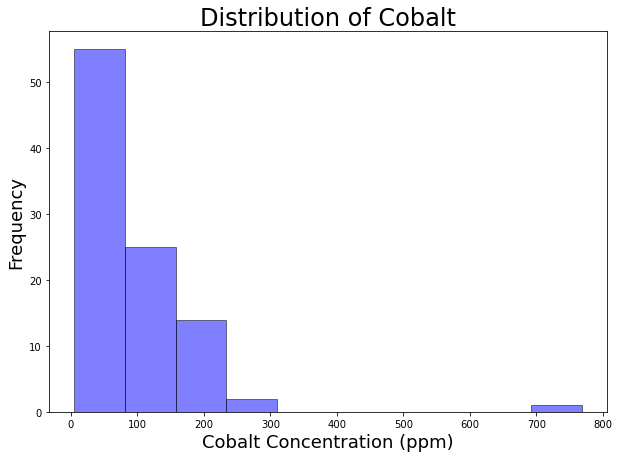

In [180]:
df_subset.Co_ppm.plot(kind='hist', color='blue', edgecolor='black', alpha = 0.5, figsize=(10,7))

plt.title('Distribution of Cobalt', size=24)
plt.xlabel('Cobalt Concentration (ppm)', size=18)
plt.ylabel('Frequency', size=18)

Text(0, 0.5, 'Frequency')

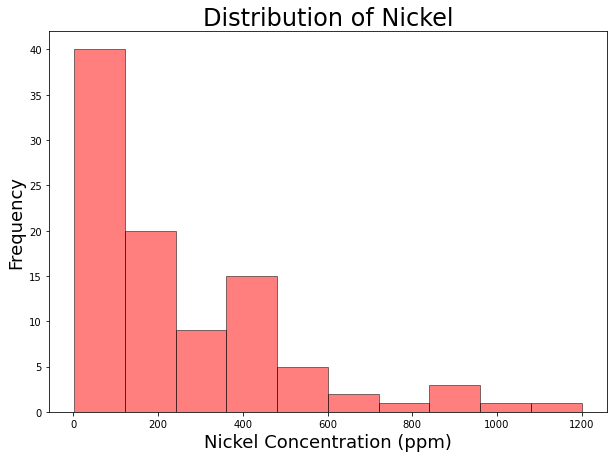

In [181]:
df_subset.Ni_ppm.plot(kind='hist', color='red', edgecolor='black', alpha = 0.5, figsize=(10,7))

plt.title('Distribution of Nickel', size=24)
plt.xlabel('Nickel Concentration (ppm)', size=18)
plt.ylabel('Frequency', size=18)

Because the distributions look somewhat normal (actually they are right skewed - should do a log transformation?), we can do an OLS (ordinary least squares) regression analysis to determine which lithology is more prospective / which lithology better predicts of high concentrations of Cobalt and Nickel ...

In [174]:
from sklearn.linear_model import LinearRegression

# create linear regression object
mlr = LinearRegression()

# fit linear regression
mlr.fit(df_subset[['lithology']], df_subset['Co_ppm'])

# get the slope and intercept of the line best fit.
print(mlr.intercept_)
# -244.92350252069903

print(mlr.coef_)
# [ 5.97694123 19.37771052]

152.55
[-100.1293617]


For both cobalt and nickel the mrl.coefficient (slope) is a negative value, meaning when basalt (lithology = 1) is accounted for, the average mineral concentration value decreases. This implies that gabbro lithology is more prospective. The p-value is low very close to zero so these values are statistically significant.

In [182]:
from statsmodels.formula.api import ols

model = ols('Co_ppm ~ lithology', data=df_subset)
fitted_model = model.fit()
fitted_model.summary()

ModuleNotFoundError: No module named 'statsmodels'

In [183]:
from statsmodels.formula.api import ols

model = ols('Ni_ppm ~ lithology', data=df_subset)
fitted_model = model.fit()
fitted_model.summary()

ModuleNotFoundError: No module named 'statsmodels'

## Geospatial Analysis

In [ ]:
import geopandas as gpd

Is the following necessary to do analysis? Do we need to convert NA values to zero?

In [ ]:
df.Co_ppm.fillna(value = 0, inplace = True) # change NA values in "Cobalt" column to zero integer vale
df.Cu_ppm.fillna(value = 0, inplace = True) # change NA values in "Copper" column to zero integer vale
df.Ni_ppm.fillna(value = 0, inplace = True) # change NA values in "Nickel" column to zero integer vale